In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, classification_report, 
                           accuracy_score, balanced_accuracy_score, f1_score,
                           precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def get_selected_features(X, feature_names, selected_vars):
    """Helper function to get indices of selected features"""
    selected_indices = [i for i, name in enumerate(feature_names) 
                       if name in selected_vars]
    return X[:, selected_indices]

def create_feature_names(n_features):
    feature_names = []
    for i in range(n_features):
        if i < 41:
            feature_names.append(f'XMEAS({i+1})')
        else:
            feature_names.append(f'XMV({i-40})')
    return feature_names

def load_data(file_path):
    data = pd.read_csv(file_path, index_col=0)
    if 'Fault' in data.columns:
        data = data.drop('Fault', axis=1)
    return data.values

def create_separate_datasets():
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for i in range(21):
        train_file = os.path.join(data_path, f'd{i:02d}.csv')
        train_data = load_data(train_file)
        
        if i == 0:
            X_train.append(train_data)
            y_train.append(np.zeros(train_data.shape[0]))
        else:
            X_train.append(train_data)
            labels = np.zeros(train_data.shape[0])
            labels[20:] = 1
            y_train.append(labels)
    
    for i in range(21):
        test_file = os.path.join(data_path, f'd{i:02d}_te.csv')
        test_data = load_data(test_file)
        
        if i == 0:
            X_test.append(test_data)
            y_test.append(np.zeros(test_data.shape[0]))
        else:
            X_test.append(test_data)
            y_test.append(np.ones(test_data.shape[0]))
    
    return (np.vstack(X_train), np.concatenate(y_train), 
            np.vstack(X_test), np.concatenate(y_test))

In [2]:
def train_mlp_classifier(X_train, X_test, y_train, y_test, model_name="", n_folds=5):
    print(f"\nTraining {model_name} (features: {X_train.shape[1]})...")
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    le = LabelEncoder()
    y_int = le.fit_transform(y_train)
    y_test_int = le.transform(y_test)
    
    param_distributions = {
        'hidden_layer_sizes': [(300,150,75), (250,125,60), (200,150,100,50)],
        'activation': ['relu', 'tanh'],
        'learning_rate_init': [0.005, 0.001, 0.0005],
        'alpha': [0.0001, 0.001],
        'batch_size': [64, 128]
    }
    
    base_mlp = MLPClassifier(
        solver='adam',
        learning_rate='adaptive',
        max_iter=2000,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=10,
        random_state=42
    )
    
    random_search = RandomizedSearchCV(
        base_mlp,
        param_distributions=param_distributions,
        n_iter=20,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    random_search.fit(X_scaled, y_int)
    best_params = random_search.best_params_
    print(f"Best parameters: {best_params}")
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    cv_accuracies = []
    cv_balanced_accs = []
    cv_precisions = []
    cv_recalls = []
    cv_aucs = []
    cv_f1s = []
    
    test_accuracies = []
    test_balanced_accs = []
    test_precisions = []
    test_recalls = []
    test_aucs = []
    test_f1s = []
    
    fold_models = []  
    
    fold = 1
    for train_idx, val_idx in skf.split(X_scaled, y_int):
        X_fold_train, X_fold_val = X_scaled[train_idx], X_scaled[val_idx]
        y_fold_train, y_fold_val = y_int[train_idx], y_int[val_idx]
        
        sampling_pipeline = Pipeline([
            ('smote', SMOTE(sampling_strategy=0.8, random_state=42)),
            ('undersampler', RandomUnderSampler(sampling_strategy=0.9, random_state=42))
        ])
        
        X_fold_train_resampled, y_fold_train_resampled = sampling_pipeline.fit_resample(
            X_fold_train, y_fold_train
        )
        
        fold_model = MLPClassifier(
            **best_params,
            solver='adam',
            learning_rate='adaptive',
            max_iter=2000,
            random_state=42
        )
        
        fold_model.fit(X_fold_train_resampled, y_fold_train_resampled)
        fold_models.append(fold_model)
        
        y_val_pred = fold_model.predict(X_fold_val)
        y_val_pred_proba = fold_model.predict_proba(X_fold_val)[:, 1]
        
        cv_accuracies.append(accuracy_score(y_fold_val, y_val_pred))
        cv_balanced_accs.append(balanced_accuracy_score(y_fold_val, y_val_pred))
        cv_precisions.append(precision_score(y_fold_val, y_val_pred))
        cv_recalls.append(recall_score(y_fold_val, y_val_pred))
        cv_aucs.append(roc_auc_score(y_fold_val, y_val_pred_proba))
        cv_f1s.append(f1_score(y_fold_val, y_val_pred))
        
        y_test_pred = fold_model.predict(X_test_scaled)
        y_test_pred_proba = fold_model.predict_proba(X_test_scaled)[:, 1]
        
        test_accuracies.append(accuracy_score(y_test_int, y_test_pred))
        test_balanced_accs.append(balanced_accuracy_score(y_test_int, y_test_pred))
        test_precisions.append(precision_score(y_test_int, y_test_pred))
        test_recalls.append(recall_score(y_test_int, y_test_pred))
        test_aucs.append(roc_auc_score(y_test_int, y_test_pred_proba))
        test_f1s.append(f1_score(y_test_int, y_test_pred))
        
        print(f"Fold {fold} - CV Balanced Acc: {cv_balanced_accs[-1]:.4f}, Test Balanced Acc: {test_balanced_accs[-1]:.4f}")
        fold += 1
    
    final_sampling_pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy=0.8, random_state=42)),
        ('undersampler', RandomUnderSampler(sampling_strategy=0.9, random_state=42))
    ])
    
    X_resampled, y_resampled = final_sampling_pipeline.fit_resample(X_scaled, y_int)
    
    final_model = MLPClassifier(
        **best_params,
        solver='adam',
        learning_rate='adaptive',
        max_iter=2000,
        random_state=42
    )
    final_model.fit(X_resampled, y_resampled)
    
    final_y_test_pred = final_model.predict(X_test_scaled)
    final_y_test_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]
    
    metrics = {
        'Model': model_name,
        'N_Features': X_train.shape[1],
        
        'Final_Test_Accuracy': accuracy_score(y_test_int, final_y_test_pred),
        'Final_Test_Balanced_Accuracy': balanced_accuracy_score(y_test_int, final_y_test_pred),
        'Final_Test_Precision': precision_score(y_test_int, final_y_test_pred),
        'Final_Test_Recall': recall_score(y_test_int, final_y_test_pred),
        'Final_Test_F1': f1_score(y_test_int, final_y_test_pred),
        'Final_Test_AUC': roc_auc_score(y_test_int, final_y_test_pred_proba),
        
        'Test_Accuracy_Mean': np.mean(test_accuracies),
        'Test_Accuracy_Std': np.std(test_accuracies),
        'Test_Balanced_Accuracy_Mean': np.mean(test_balanced_accs),
        'Test_Balanced_Accuracy_Std': np.std(test_balanced_accs),
        'Test_Precision_Mean': np.mean(test_precisions),
        'Test_Precision_Std': np.std(test_precisions),
        'Test_Recall_Mean': np.mean(test_recalls),
        'Test_Recall_Std': np.std(test_recalls),
        'Test_F1_Mean': np.mean(test_f1s),
        'Test_F1_Std': np.std(test_f1s),
        'Test_AUC_Mean': np.mean(test_aucs),
        'Test_AUC_Std': np.std(test_aucs),
        
        'CV_Accuracy_Mean': np.mean(cv_accuracies),
        'CV_Accuracy_Std': np.std(cv_accuracies),
        'CV_Balanced_Accuracy_Mean': np.mean(cv_balanced_accs),
        'CV_Balanced_Accuracy_Std': np.std(cv_balanced_accs),
        'CV_Precision_Mean': np.mean(cv_precisions),
        'CV_Precision_Std': np.std(cv_precisions),
        'CV_Recall_Mean': np.mean(cv_recalls),
        'CV_Recall_Std': np.std(cv_recalls),
        'CV_F1_Mean': np.mean(cv_f1s),
        'CV_F1_Std': np.std(cv_f1s),
        'CV_AUC_Mean': np.mean(cv_aucs),
        'CV_AUC_Std': np.std(cv_aucs)
    }
    
    metrics.update({f'best_{k}': v for k, v in best_params.items()})
    
    cm = confusion_matrix(y_test_int, final_y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return metrics, final_model

In [3]:
def train_xgboost_classifier(X_train, X_test, y_train, y_test, model_name="", feature_names=None, n_folds=5):
    print(f"\nTraining {model_name} (features: {X_train.shape[1]})...")
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    le = LabelEncoder()
    y_int = le.fit_transform(y_train)
    y_test_int = le.transform(y_test)
    
    param_distributions = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2]
    }
    
    base_xgb = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        n_jobs=-1
    )
    
    random_search = RandomizedSearchCV(
        base_xgb,
        param_distributions=param_distributions,
        n_iter=20,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    random_search.fit(X_scaled, y_int)
    best_params = random_search.best_params_
    print(f"Best parameters: {best_params}")
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    cv_accuracies = []
    cv_balanced_accs = []
    cv_precisions = []
    cv_recalls = []
    cv_aucs = []
    cv_f1s = []
    
    test_accuracies = []
    test_balanced_accs = []
    test_precisions = []
    test_recalls = []
    test_aucs = []
    test_f1s = []
    
    fold_models = []  
    
    fold = 1
    for train_idx, val_idx in skf.split(X_scaled, y_int):
        X_fold_train, X_fold_val = X_scaled[train_idx], X_scaled[val_idx]
        y_fold_train, y_fold_val = y_int[train_idx], y_int[val_idx]
        
        sampling_pipeline = Pipeline([
            ('smote', SMOTE(sampling_strategy=0.8, random_state=42)),
            ('undersampler', RandomUnderSampler(sampling_strategy=0.9, random_state=42))
        ])
        
        X_fold_train_resampled, y_fold_train_resampled = sampling_pipeline.fit_resample(
            X_fold_train, y_fold_train
        )
        
        fold_model = xgb.XGBClassifier(
            **best_params,
            objective='binary:logistic',
            random_state=42,
            n_jobs=-1
        )
        
        fold_model.fit(X_fold_train_resampled, y_fold_train_resampled)
        fold_models.append(fold_model)
        
        y_val_pred = fold_model.predict(X_fold_val)
        y_val_pred_proba = fold_model.predict_proba(X_fold_val)[:, 1]
        
        cv_accuracies.append(accuracy_score(y_fold_val, y_val_pred))
        cv_balanced_accs.append(balanced_accuracy_score(y_fold_val, y_val_pred))
        cv_precisions.append(precision_score(y_fold_val, y_val_pred))
        cv_recalls.append(recall_score(y_fold_val, y_val_pred))
        cv_aucs.append(roc_auc_score(y_fold_val, y_val_pred_proba))
        cv_f1s.append(f1_score(y_fold_val, y_val_pred))
        
        y_test_pred = fold_model.predict(X_test_scaled)
        y_test_pred_proba = fold_model.predict_proba(X_test_scaled)[:, 1]
        
        test_accuracies.append(accuracy_score(y_test_int, y_test_pred))
        test_balanced_accs.append(balanced_accuracy_score(y_test_int, y_test_pred))
        test_precisions.append(precision_score(y_test_int, y_test_pred))
        test_recalls.append(recall_score(y_test_int, y_test_pred))
        test_aucs.append(roc_auc_score(y_test_int, y_test_pred_proba))
        test_f1s.append(f1_score(y_test_int, y_test_pred))
        
        print(f"Fold {fold} - CV Balanced Acc: {cv_balanced_accs[-1]:.4f}, Test Balanced Acc: {test_balanced_accs[-1]:.4f}")
        fold += 1
    
    final_sampling_pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy=0.8, random_state=42)),
        ('undersampler', RandomUnderSampler(sampling_strategy=0.9, random_state=42))
    ])
    
    X_resampled, y_resampled = final_sampling_pipeline.fit_resample(X_scaled, y_int)
    
    final_model = xgb.XGBClassifier(
        **best_params,
        objective='binary:logistic',
        random_state=42,
        n_jobs=-1
    )
    final_model.fit(X_resampled, y_resampled)
    
    final_y_test_pred = final_model.predict(X_test_scaled)
    final_y_test_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]
    
    metrics = {
        'Model': model_name,
        'N_Features': X_train.shape[1],
        
        'Final_Test_Accuracy': accuracy_score(y_test_int, final_y_test_pred),
        'Final_Test_Balanced_Accuracy': balanced_accuracy_score(y_test_int, final_y_test_pred),
        'Final_Test_Precision': precision_score(y_test_int, final_y_test_pred),
        'Final_Test_Recall': recall_score(y_test_int, final_y_test_pred),
        'Final_Test_F1': f1_score(y_test_int, final_y_test_pred),
        'Final_Test_AUC': roc_auc_score(y_test_int, final_y_test_pred_proba),
        
        'Test_Accuracy_Mean': np.mean(test_accuracies),
        'Test_Accuracy_Std': np.std(test_accuracies),
        'Test_Balanced_Accuracy_Mean': np.mean(test_balanced_accs),
        'Test_Balanced_Accuracy_Std': np.std(test_balanced_accs),
        'Test_Precision_Mean': np.mean(test_precisions),
        'Test_Precision_Std': np.std(test_precisions),
        'Test_Recall_Mean': np.mean(test_recalls),
        'Test_Recall_Std': np.std(test_recalls),
        'Test_F1_Mean': np.mean(test_f1s),
        'Test_F1_Std': np.std(test_f1s),
        'Test_AUC_Mean': np.mean(test_aucs),
        'Test_AUC_Std': np.std(test_aucs),
        
        'CV_Accuracy_Mean': np.mean(cv_accuracies),
        'CV_Accuracy_Std': np.std(cv_accuracies),
        'CV_Balanced_Accuracy_Mean': np.mean(cv_balanced_accs),
        'CV_Balanced_Accuracy_Std': np.std(cv_balanced_accs),
        'CV_Precision_Mean': np.mean(cv_precisions),
        'CV_Precision_Std': np.std(cv_precisions),
        'CV_Recall_Mean': np.mean(cv_recalls),
        'CV_Recall_Std': np.std(cv_recalls),
        'CV_F1_Mean': np.mean(cv_f1s),
        'CV_F1_Std': np.std(cv_f1s),
        'CV_AUC_Mean': np.mean(cv_aucs),
        'CV_AUC_Std': np.std(cv_aucs)
    }
    
    metrics.update({f'best_{k}': v for k, v in best_params.items()})
    
    cm = confusion_matrix(y_test_int, final_y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    if X_train.shape[1] <= 20 and feature_names is not None:
        if isinstance(feature_names, list):
            feature_names_subset = feature_names[:X_train.shape[1]]
        else:
            feature_names_subset = feature_names
            
        plt.figure(figsize=(10, 6))
        feature_importance = pd.DataFrame({
            'feature': feature_names_subset,
            'importance': final_model.feature_importances_
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        
        sns.barplot(x='importance', y='feature', data=feature_importance)
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.show()
    
    return metrics, final_model

In [4]:
def train_knn_classifier(X_train, X_test, y_train, y_test, model_name="", n_folds=5):
    print(f"\nTraining {model_name} (features: {X_train.shape[1]})...")
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    le = LabelEncoder()
    y_int = le.fit_transform(y_train)
    y_test_int = le.transform(y_test)
    
    param_distributions = {
        'n_neighbors': [3, 5, 7, 9, 11, 13],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'p': [1, 2],  
        'leaf_size': [20, 30, 40]
    }
    
    base_knn = KNeighborsClassifier(
        n_jobs=-1
    )
    
    random_search = RandomizedSearchCV(
        base_knn,
        param_distributions=param_distributions,
        n_iter=20,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    random_search.fit(X_scaled, y_int)
    best_params = random_search.best_params_
    print(f"Best parameters: {best_params}")
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    cv_accuracies = []
    cv_balanced_accs = []
    cv_precisions = []
    cv_recalls = []
    cv_aucs = []
    cv_f1s = []
    
    test_accuracies = []
    test_balanced_accs = []
    test_precisions = []
    test_recalls = []
    test_aucs = []
    test_f1s = []
    
    fold_models = []  
    
    fold = 1
    for train_idx, val_idx in skf.split(X_scaled, y_int):
        X_fold_train, X_fold_val = X_scaled[train_idx], X_scaled[val_idx]
        y_fold_train, y_fold_val = y_int[train_idx], y_int[val_idx]
        
        sampling_pipeline = Pipeline([
            ('smote', SMOTE(sampling_strategy=0.8, random_state=42)),
            ('undersampler', RandomUnderSampler(sampling_strategy=0.9, random_state=42))
        ])
        
        X_fold_train_resampled, y_fold_train_resampled = sampling_pipeline.fit_resample(
            X_fold_train, y_fold_train
        )
        
        fold_model = KNeighborsClassifier(
            **best_params,
            n_jobs=-1
        )
        
        fold_model.fit(X_fold_train_resampled, y_fold_train_resampled)
        fold_models.append(fold_model)
        
        y_val_pred = fold_model.predict(X_fold_val)
        y_val_pred_proba = fold_model.predict_proba(X_fold_val)[:, 1]
        
        cv_accuracies.append(accuracy_score(y_fold_val, y_val_pred))
        cv_balanced_accs.append(balanced_accuracy_score(y_fold_val, y_val_pred))
        cv_precisions.append(precision_score(y_fold_val, y_val_pred))
        cv_recalls.append(recall_score(y_fold_val, y_val_pred))
        cv_aucs.append(roc_auc_score(y_fold_val, y_val_pred_proba))
        cv_f1s.append(f1_score(y_fold_val, y_val_pred))
        
        y_test_pred = fold_model.predict(X_test_scaled)
        y_test_pred_proba = fold_model.predict_proba(X_test_scaled)[:, 1]
        
        test_accuracies.append(accuracy_score(y_test_int, y_test_pred))
        test_balanced_accs.append(balanced_accuracy_score(y_test_int, y_test_pred))
        test_precisions.append(precision_score(y_test_int, y_test_pred))
        test_recalls.append(recall_score(y_test_int, y_test_pred))
        test_aucs.append(roc_auc_score(y_test_int, y_test_pred_proba))
        test_f1s.append(f1_score(y_test_int, y_test_pred))
        
        print(f"Fold {fold} - CV Balanced Acc: {cv_balanced_accs[-1]:.4f}, Test Balanced Acc: {test_balanced_accs[-1]:.4f}")
        fold += 1
    
    final_sampling_pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy=0.8, random_state=42)),
        ('undersampler', RandomUnderSampler(sampling_strategy=0.9, random_state=42))
    ])
    
    X_resampled, y_resampled = final_sampling_pipeline.fit_resample(X_scaled, y_int)
    
    final_model = KNeighborsClassifier(
        **best_params,
        n_jobs=-1
    )
    final_model.fit(X_resampled, y_resampled)
    
    final_y_test_pred = final_model.predict(X_test_scaled)
    final_y_test_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]
    
    metrics = {
        'Model': model_name,
        'N_Features': X_train.shape[1],
        
        'Final_Test_Accuracy': accuracy_score(y_test_int, final_y_test_pred),
        'Final_Test_Balanced_Accuracy': balanced_accuracy_score(y_test_int, final_y_test_pred),
        'Final_Test_Precision': precision_score(y_test_int, final_y_test_pred),
        'Final_Test_Recall': recall_score(y_test_int, final_y_test_pred),
        'Final_Test_F1': f1_score(y_test_int, final_y_test_pred),
        'Final_Test_AUC': roc_auc_score(y_test_int, final_y_test_pred_proba),
        
        'Test_Accuracy_Mean': np.mean(test_accuracies),
        'Test_Accuracy_Std': np.std(test_accuracies),
        'Test_Balanced_Accuracy_Mean': np.mean(test_balanced_accs),
        'Test_Balanced_Accuracy_Std': np.std(test_balanced_accs),
        'Test_Precision_Mean': np.mean(test_precisions),
        'Test_Precision_Std': np.std(test_precisions),
        'Test_Recall_Mean': np.mean(test_recalls),
        'Test_Recall_Std': np.std(test_recalls),
        'Test_F1_Mean': np.mean(test_f1s),
        'Test_F1_Std': np.std(test_f1s),
        'Test_AUC_Mean': np.mean(test_aucs),
        'Test_AUC_Std': np.std(test_aucs),
        
        'CV_Accuracy_Mean': np.mean(cv_accuracies),
        'CV_Accuracy_Std': np.std(cv_accuracies),
        'CV_Balanced_Accuracy_Mean': np.mean(cv_balanced_accs),
        'CV_Balanced_Accuracy_Std': np.std(cv_balanced_accs),
        'CV_Precision_Mean': np.mean(cv_precisions),
        'CV_Precision_Std': np.std(cv_precisions),
        'CV_Recall_Mean': np.mean(cv_recalls),
        'CV_Recall_Std': np.std(cv_recalls),
        'CV_F1_Mean': np.mean(cv_f1s),
        'CV_F1_Std': np.std(cv_f1s),
        'CV_AUC_Mean': np.mean(cv_aucs),
        'CV_AUC_Std': np.std(cv_aucs)
    }
    
    metrics.update({f'best_{k}': v for k, v in best_params.items()})
    
    cm = confusion_matrix(y_test_int, final_y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return metrics, final_model

Loading and preparing datasets...

Training mlp52var (features: 52)...
Best parameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (300, 150, 75), 'batch_size': 128, 'alpha': 0.0001, 'activation': 'relu'}
Fold 1 - CV Balanced Acc: 0.6940, Test Balanced Acc: 0.6772
Fold 2 - CV Balanced Acc: 0.6629, Test Balanced Acc: 0.6606
Fold 3 - CV Balanced Acc: 0.6702, Test Balanced Acc: 0.6545
Fold 4 - CV Balanced Acc: 0.7286, Test Balanced Acc: 0.6214
Fold 5 - CV Balanced Acc: 0.7085, Test Balanced Acc: 0.6366


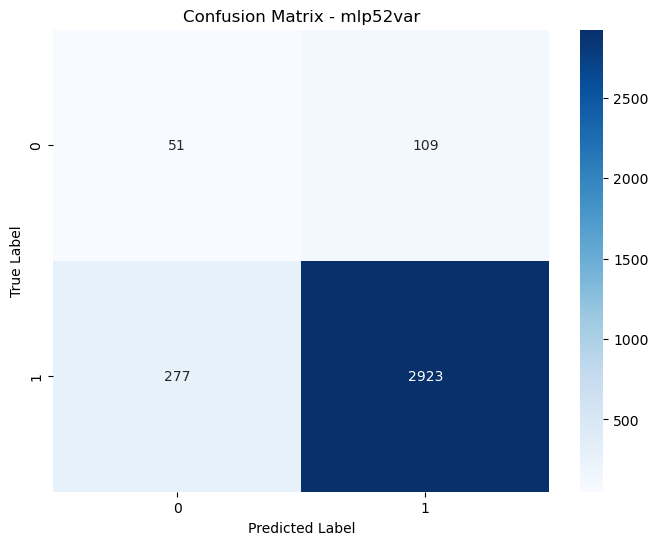


Training mlp7var (features: 7)...
Best parameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (300, 150, 75), 'batch_size': 128, 'alpha': 0.001, 'activation': 'relu'}
Fold 1 - CV Balanced Acc: 0.6694, Test Balanced Acc: 0.7077
Fold 2 - CV Balanced Acc: 0.6353, Test Balanced Acc: 0.7314
Fold 3 - CV Balanced Acc: 0.6597, Test Balanced Acc: 0.6773
Fold 4 - CV Balanced Acc: 0.6875, Test Balanced Acc: 0.7216
Fold 5 - CV Balanced Acc: 0.7006, Test Balanced Acc: 0.6405


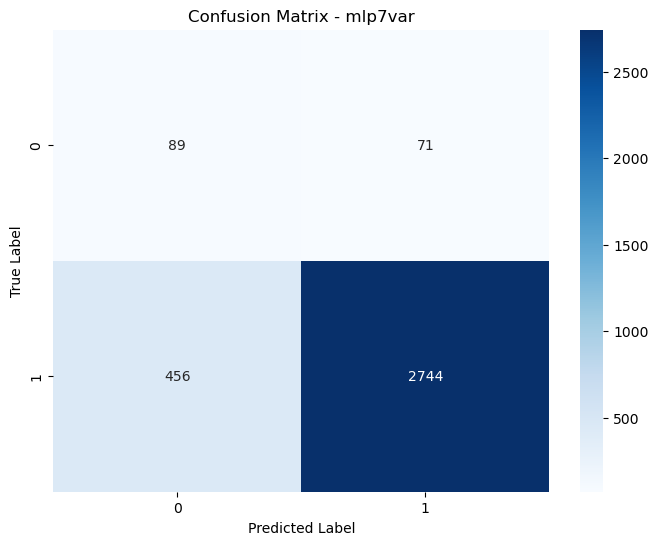


Training mlp10var (features: 10)...
Best parameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (250, 125, 60), 'batch_size': 64, 'alpha': 0.0001, 'activation': 'relu'}
Fold 1 - CV Balanced Acc: 0.6833, Test Balanced Acc: 0.7195
Fold 2 - CV Balanced Acc: 0.6524, Test Balanced Acc: 0.7266
Fold 3 - CV Balanced Acc: 0.6666, Test Balanced Acc: 0.6617
Fold 4 - CV Balanced Acc: 0.7047, Test Balanced Acc: 0.7383
Fold 5 - CV Balanced Acc: 0.6931, Test Balanced Acc: 0.7070


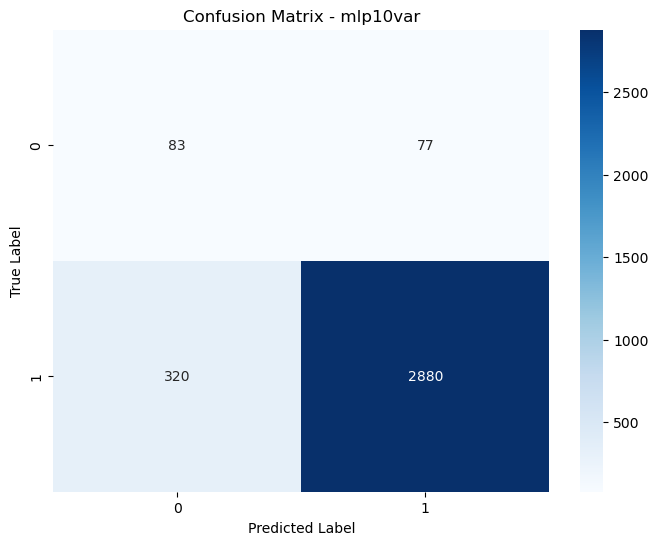


Training mlp12var (features: 12)...
Best parameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (250, 125, 60), 'batch_size': 64, 'alpha': 0.001, 'activation': 'relu'}
Fold 1 - CV Balanced Acc: 0.6852, Test Balanced Acc: 0.6937
Fold 2 - CV Balanced Acc: 0.6550, Test Balanced Acc: 0.6831
Fold 3 - CV Balanced Acc: 0.6564, Test Balanced Acc: 0.7263
Fold 4 - CV Balanced Acc: 0.6943, Test Balanced Acc: 0.7642
Fold 5 - CV Balanced Acc: 0.7027, Test Balanced Acc: 0.6925


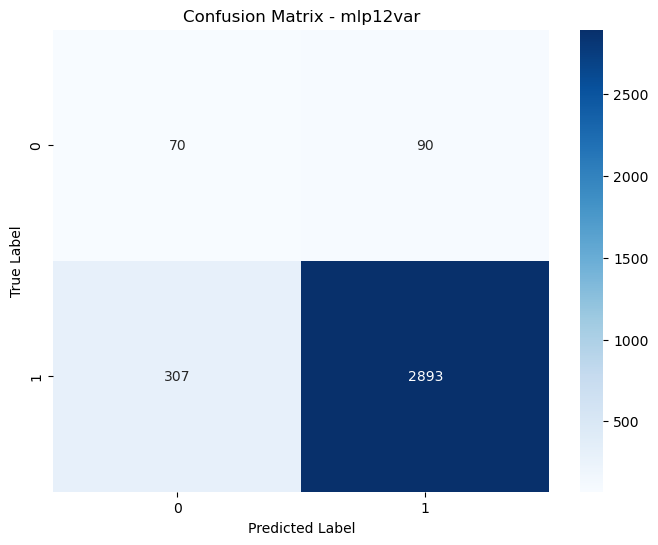


Training mlp15var (features: 15)...
Best parameters: {'learning_rate_init': 0.005, 'hidden_layer_sizes': (250, 125, 60), 'batch_size': 128, 'alpha': 0.0001, 'activation': 'relu'}
Fold 1 - CV Balanced Acc: 0.6813, Test Balanced Acc: 0.6675
Fold 2 - CV Balanced Acc: 0.6602, Test Balanced Acc: 0.6564
Fold 3 - CV Balanced Acc: 0.6585, Test Balanced Acc: 0.7163
Fold 4 - CV Balanced Acc: 0.7067, Test Balanced Acc: 0.6711
Fold 5 - CV Balanced Acc: 0.7067, Test Balanced Acc: 0.6377


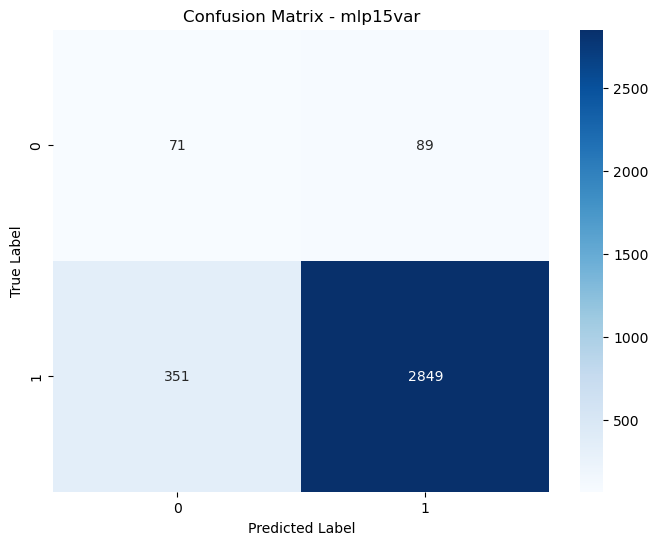


Training knn52var (features: 52)...
Best parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'metric': 'manhattan', 'leaf_size': 20}
Fold 1 - CV Balanced Acc: 0.6530, Test Balanced Acc: 0.5044
Fold 2 - CV Balanced Acc: 0.6160, Test Balanced Acc: 0.5258
Fold 3 - CV Balanced Acc: 0.6200, Test Balanced Acc: 0.5191
Fold 4 - CV Balanced Acc: 0.6622, Test Balanced Acc: 0.5244
Fold 5 - CV Balanced Acc: 0.6549, Test Balanced Acc: 0.5339


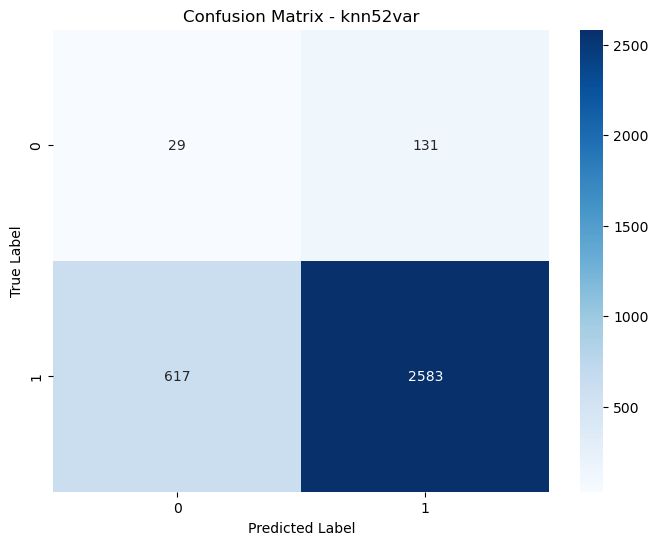


Training knn7var (features: 7)...
Best parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'metric': 'manhattan', 'leaf_size': 20}
Fold 1 - CV Balanced Acc: 0.5997, Test Balanced Acc: 0.6367
Fold 2 - CV Balanced Acc: 0.5692, Test Balanced Acc: 0.6300
Fold 3 - CV Balanced Acc: 0.5740, Test Balanced Acc: 0.6116
Fold 4 - CV Balanced Acc: 0.6181, Test Balanced Acc: 0.6387
Fold 5 - CV Balanced Acc: 0.6149, Test Balanced Acc: 0.6056


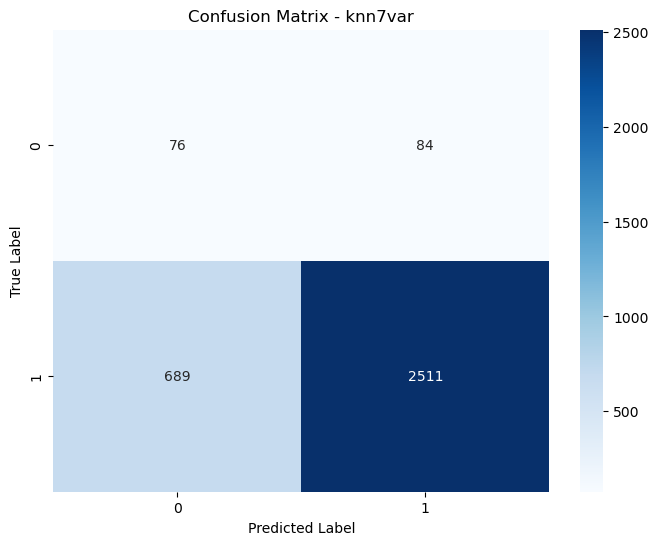


Training knn10var (features: 10)...
Best parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'metric': 'manhattan', 'leaf_size': 20}
Fold 1 - CV Balanced Acc: 0.5850, Test Balanced Acc: 0.6350
Fold 2 - CV Balanced Acc: 0.5566, Test Balanced Acc: 0.6287
Fold 3 - CV Balanced Acc: 0.5655, Test Balanced Acc: 0.6139
Fold 4 - CV Balanced Acc: 0.6119, Test Balanced Acc: 0.6331
Fold 5 - CV Balanced Acc: 0.6043, Test Balanced Acc: 0.6289


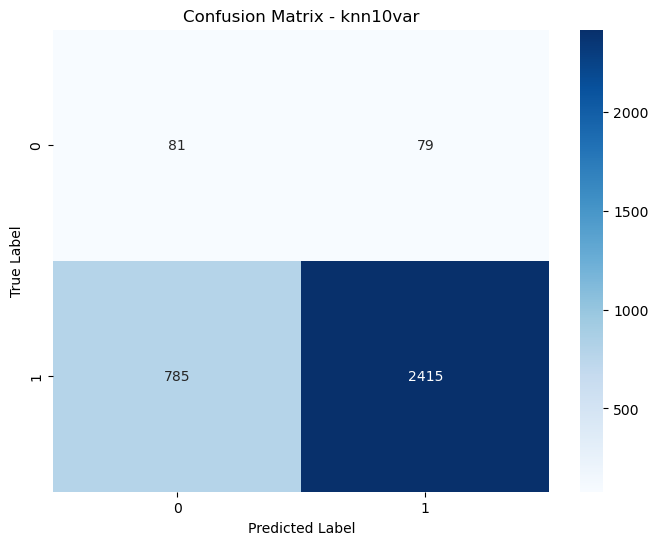


Training knn12var (features: 12)...
Best parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'metric': 'manhattan', 'leaf_size': 20}
Fold 1 - CV Balanced Acc: 0.5972, Test Balanced Acc: 0.6195
Fold 2 - CV Balanced Acc: 0.5596, Test Balanced Acc: 0.6020
Fold 3 - CV Balanced Acc: 0.5746, Test Balanced Acc: 0.5914
Fold 4 - CV Balanced Acc: 0.6188, Test Balanced Acc: 0.5962
Fold 5 - CV Balanced Acc: 0.6049, Test Balanced Acc: 0.6011


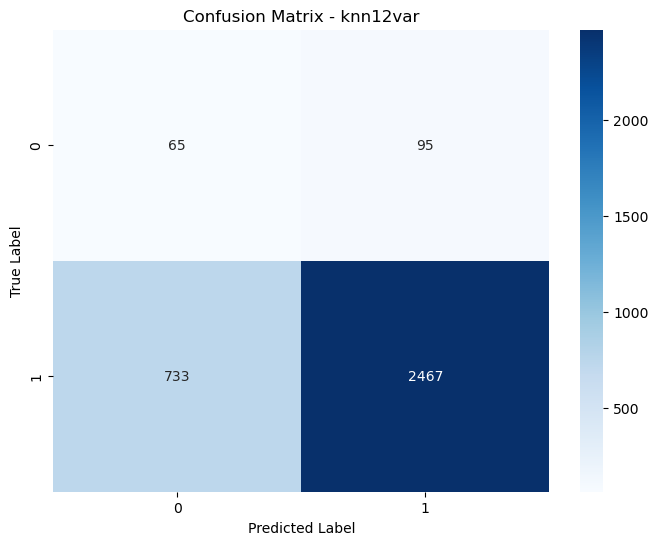


Training knn15var (features: 15)...
Best parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'metric': 'manhattan', 'leaf_size': 20}
Fold 1 - CV Balanced Acc: 0.6248, Test Balanced Acc: 0.5591
Fold 2 - CV Balanced Acc: 0.5839, Test Balanced Acc: 0.5637
Fold 3 - CV Balanced Acc: 0.5899, Test Balanced Acc: 0.5655
Fold 4 - CV Balanced Acc: 0.6341, Test Balanced Acc: 0.5614
Fold 5 - CV Balanced Acc: 0.6184, Test Balanced Acc: 0.5672


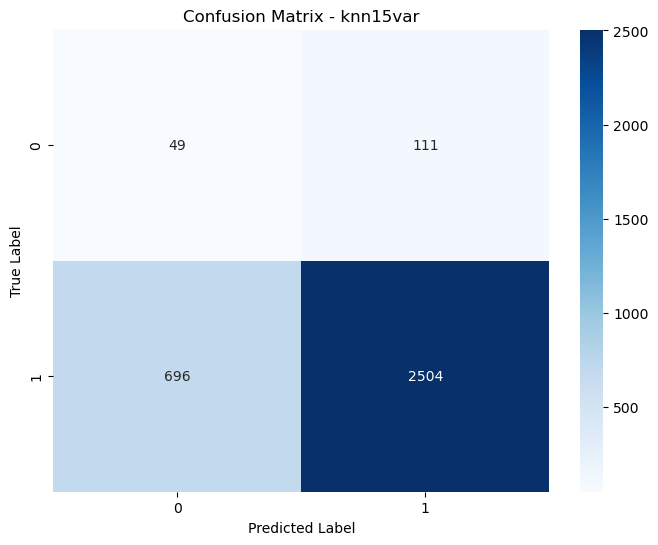


Training xgb52var (features: 52)...
Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
Fold 1 - CV Balanced Acc: 0.7863, Test Balanced Acc: 0.6894
Fold 2 - CV Balanced Acc: 0.7486, Test Balanced Acc: 0.6755
Fold 3 - CV Balanced Acc: 0.7278, Test Balanced Acc: 0.6642
Fold 4 - CV Balanced Acc: 0.7913, Test Balanced Acc: 0.7055
Fold 5 - CV Balanced Acc: 0.7856, Test Balanced Acc: 0.6867


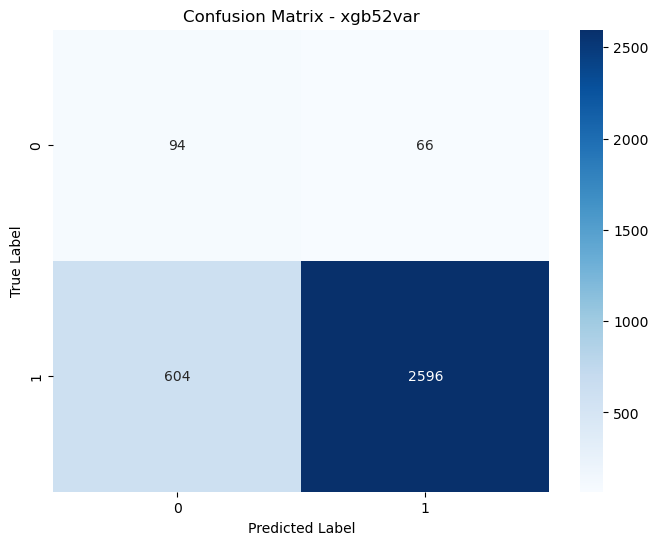


Training xgb7var (features: 7)...
Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}
Fold 1 - CV Balanced Acc: 0.8079, Test Balanced Acc: 0.7133
Fold 2 - CV Balanced Acc: 0.7631, Test Balanced Acc: 0.7270
Fold 3 - CV Balanced Acc: 0.7457, Test Balanced Acc: 0.7048
Fold 4 - CV Balanced Acc: 0.7919, Test Balanced Acc: 0.7216
Fold 5 - CV Balanced Acc: 0.7887, Test Balanced Acc: 0.7125


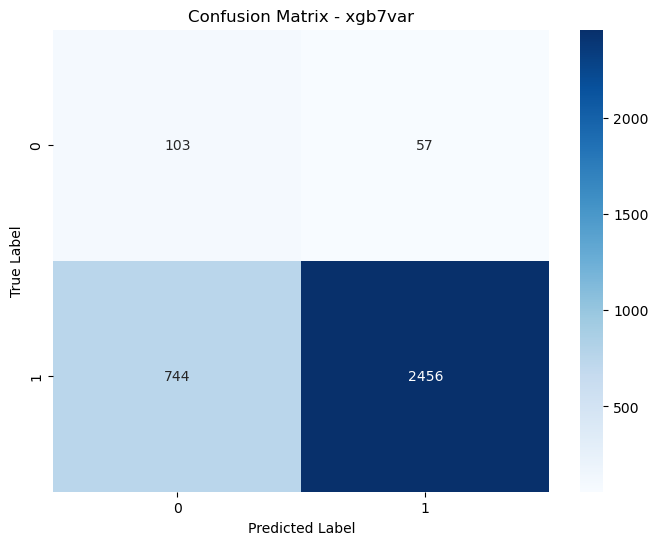

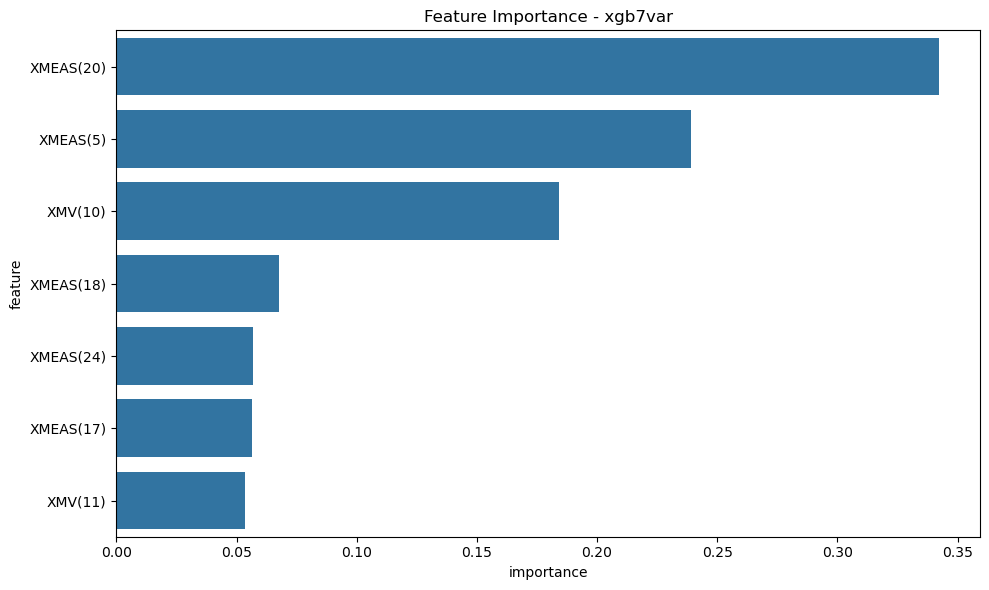


Training xgb10var (features: 10)...
Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}
Fold 1 - CV Balanced Acc: 0.8089, Test Balanced Acc: 0.7284
Fold 2 - CV Balanced Acc: 0.7595, Test Balanced Acc: 0.7219
Fold 3 - CV Balanced Acc: 0.7514, Test Balanced Acc: 0.7048
Fold 4 - CV Balanced Acc: 0.7974, Test Balanced Acc: 0.7195
Fold 5 - CV Balanced Acc: 0.7961, Test Balanced Acc: 0.7225


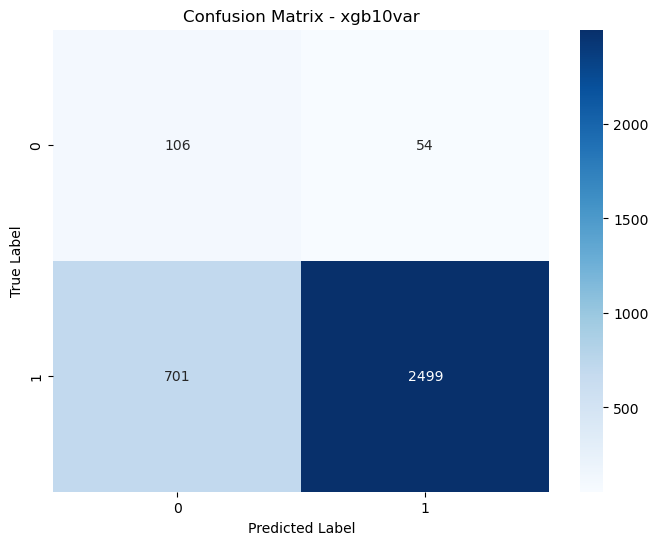

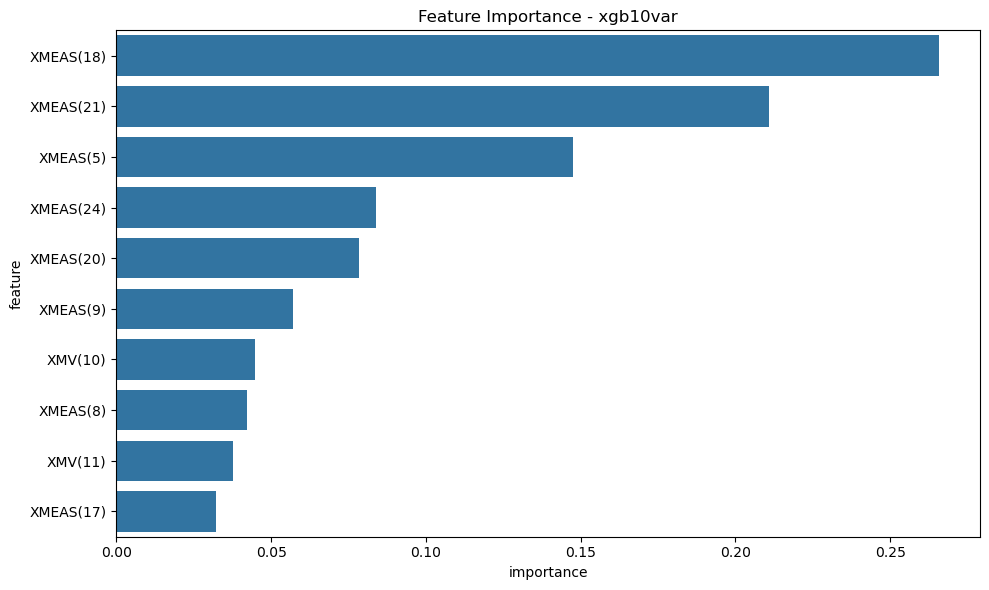


Training xgb12var (features: 12)...
Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}
Fold 1 - CV Balanced Acc: 0.7911, Test Balanced Acc: 0.7031
Fold 2 - CV Balanced Acc: 0.7582, Test Balanced Acc: 0.6933
Fold 3 - CV Balanced Acc: 0.7497, Test Balanced Acc: 0.6894
Fold 4 - CV Balanced Acc: 0.7982, Test Balanced Acc: 0.7245
Fold 5 - CV Balanced Acc: 0.7891, Test Balanced Acc: 0.7045


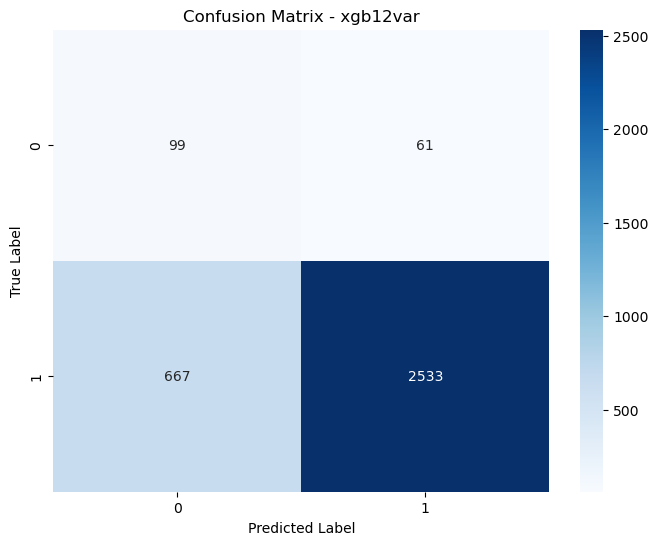

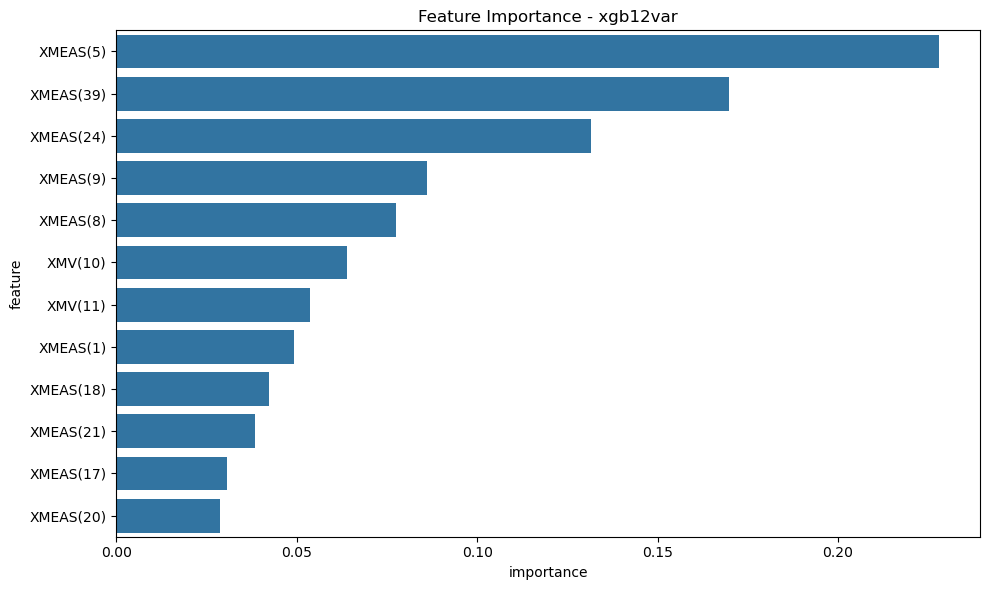


Training xgb15var (features: 15)...
Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
Fold 1 - CV Balanced Acc: 0.7981, Test Balanced Acc: 0.6919
Fold 2 - CV Balanced Acc: 0.7393, Test Balanced Acc: 0.6870
Fold 3 - CV Balanced Acc: 0.7278, Test Balanced Acc: 0.6856
Fold 4 - CV Balanced Acc: 0.7793, Test Balanced Acc: 0.7114
Fold 5 - CV Balanced Acc: 0.7816, Test Balanced Acc: 0.6947


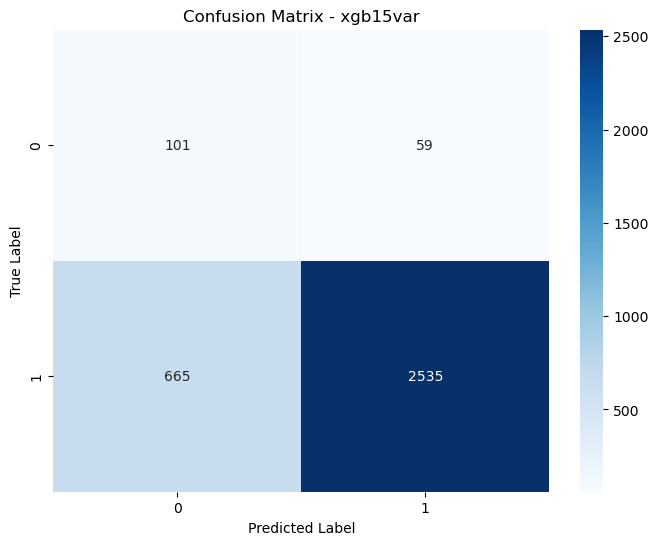

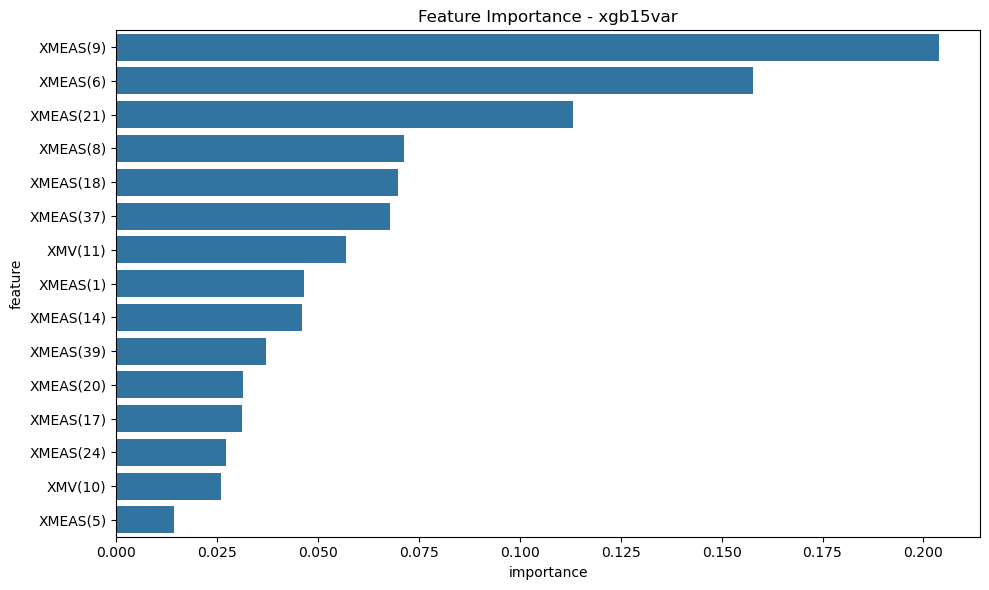


Model Comparison (sorted by CV Balanced Accuracy Mean):
          N_Features  Final_Test_Accuracy  Final_Test_Balanced_Accuracy  \
Model                                                                     
xgb10var          10               0.7753                        0.7217   
xgb7var            7               0.7616                        0.7056   
xgb12var          12               0.7833                        0.7052   
xgb52var          52               0.8006                        0.6994   
xgb15var          15               0.7845                        0.7117   
mlp52var          52               0.8851                        0.6161   
mlp15var          15               0.8690                        0.6670   
mlp10var          10               0.8818                        0.7094   
mlp12var          12               0.8818                        0.6708   
mlp7var            7               0.8432                        0.7069   
knn52var          52               0.7774  

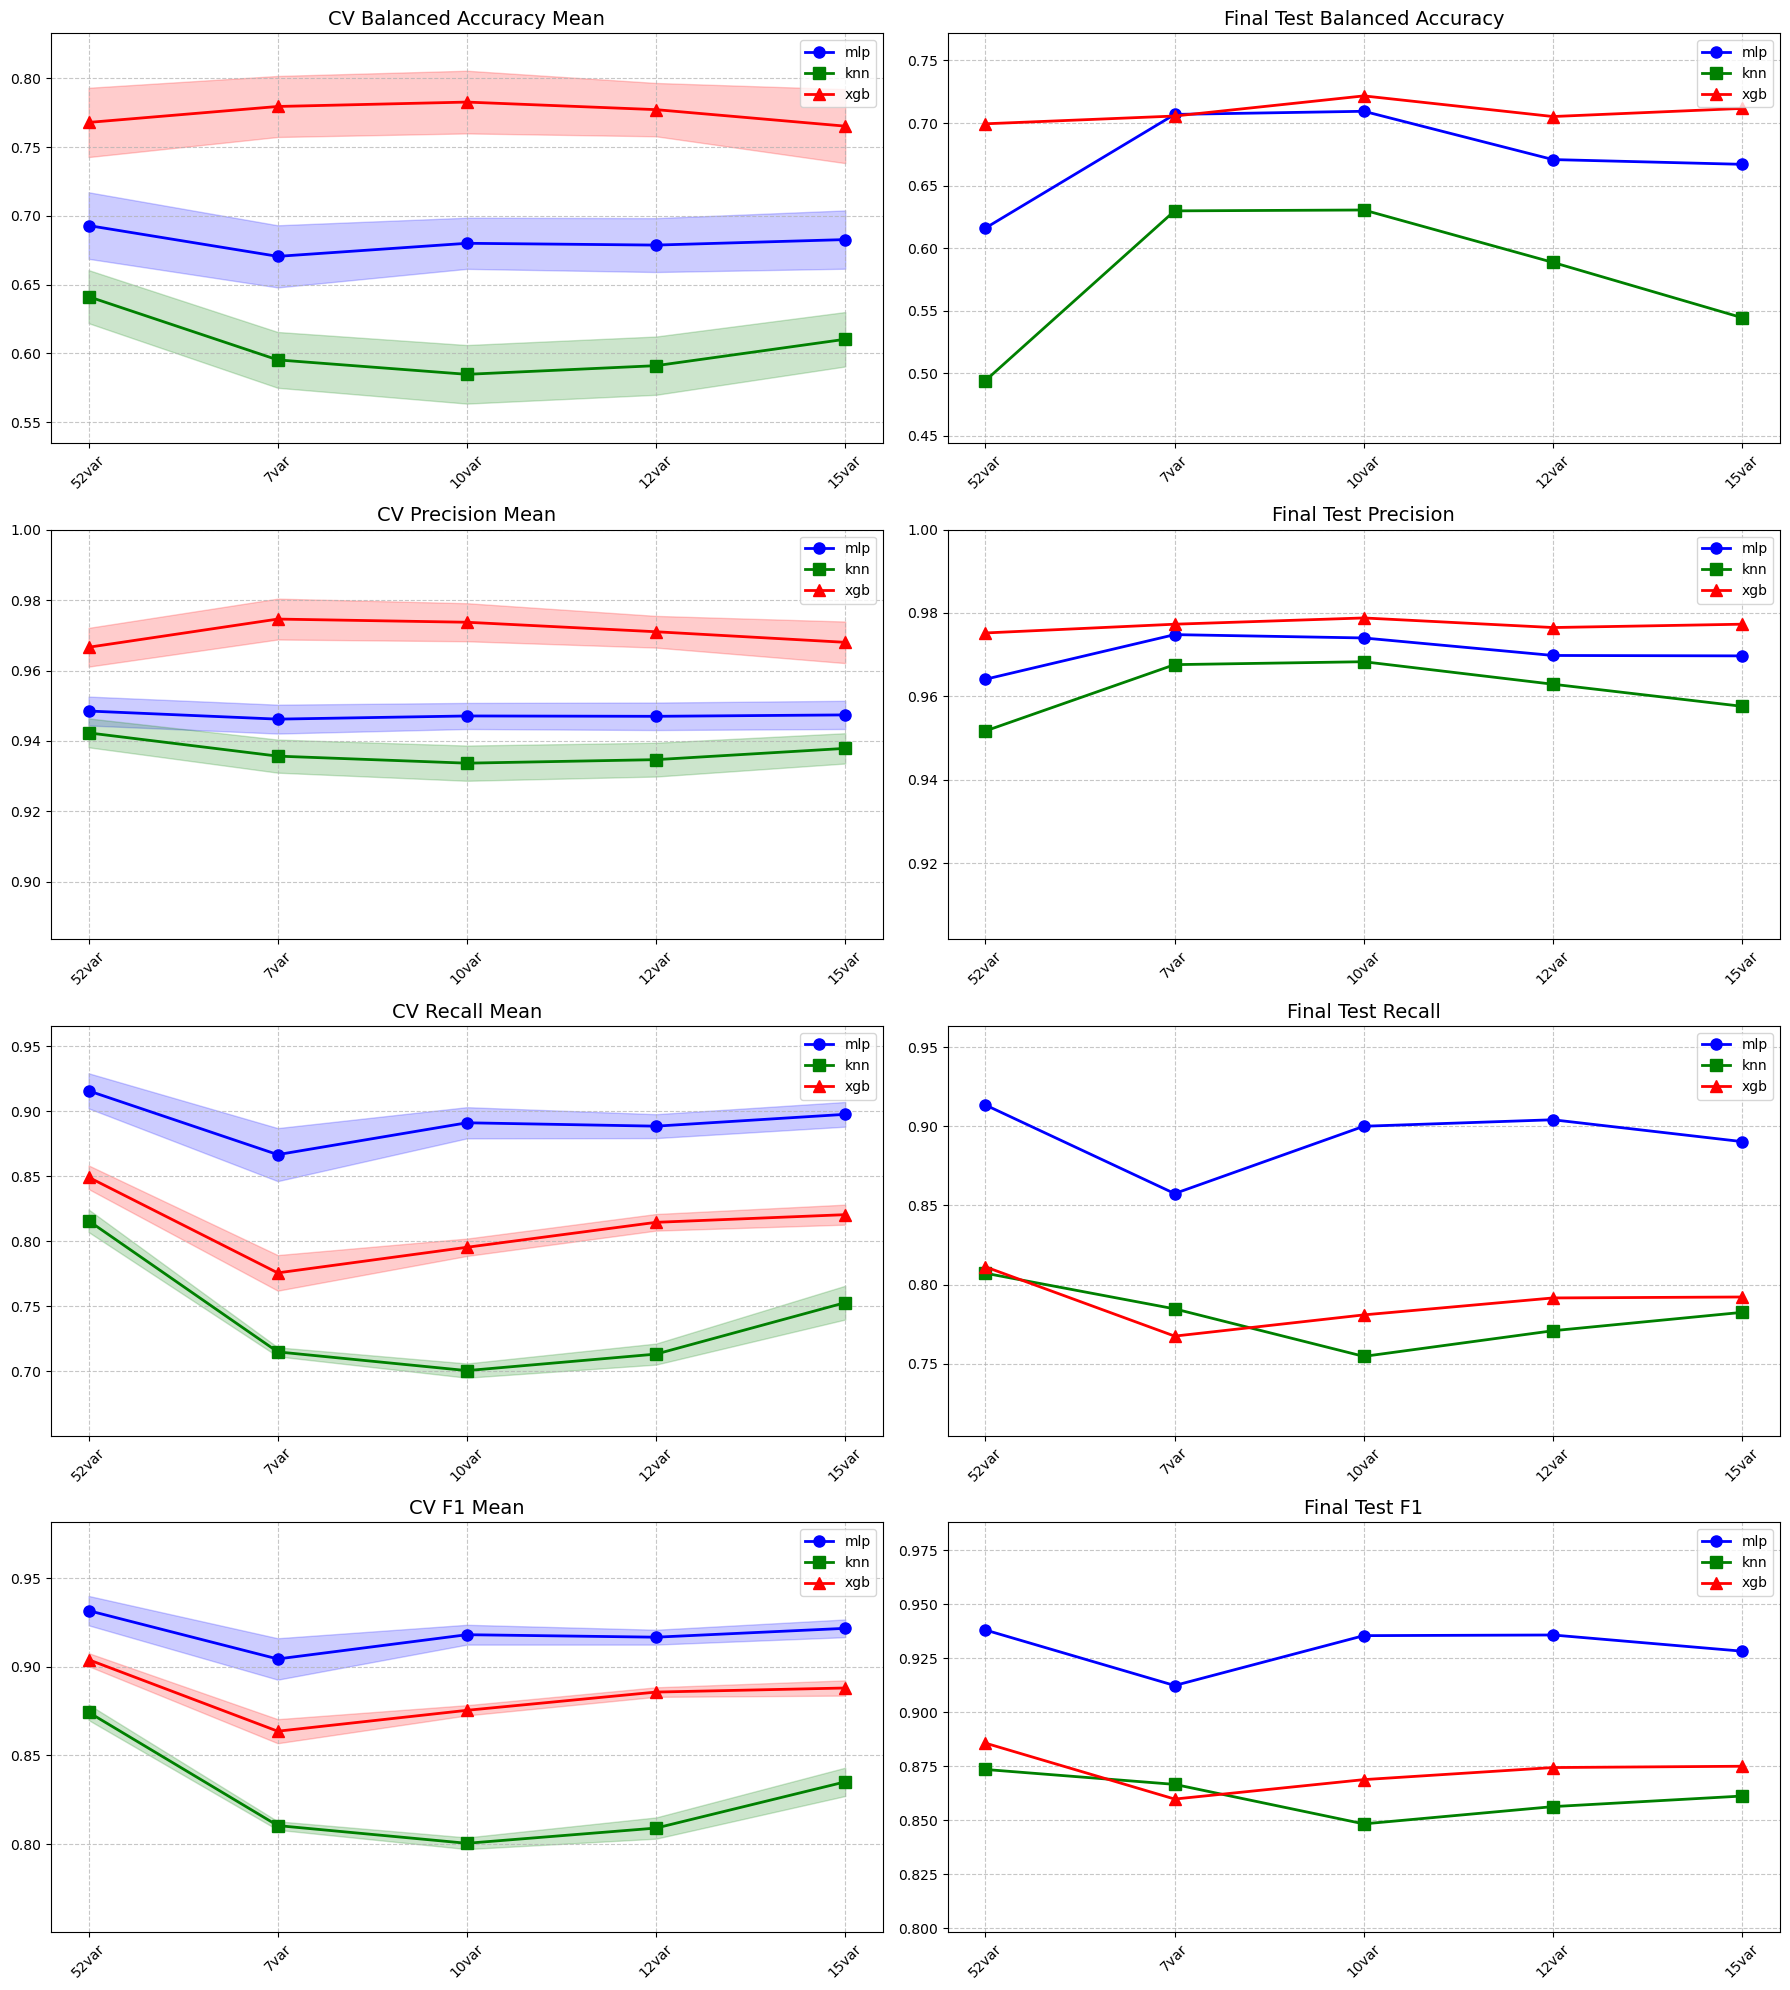


Best model of each type (by CV Balanced Accuracy):
mlp: mlp52var - CV Balanced Acc: 0.6929 ± 0.0242, Test Balanced Acc: 0.6161, F1 Score: 0.9381
knn: knn52var - CV Balanced Acc: 0.6412 ± 0.0193, Test Balanced Acc: 0.4942, F1 Score: 0.8735
xgb: xgb10var - CV Balanced Acc: 0.7827 ± 0.0228, Test Balanced Acc: 0.7217, F1 Score: 0.8688


In [5]:
if __name__ == "__main__":
    data_path = 'Downloads/data_tep/'
    
    shap_vars = ["XMV(11)", "XMEAS(17)", "XMEAS(20)", "XMV(10)", 
                 "XMEAS(18)", "XMEAS(5)", "XMEAS(24)", "XMEAS(9)", 
                 "XMEAS(21)", "XMEAS(8)", "XMEAS(39)", "XMEAS(1)",
                 "XMEAS(37)", "XMEAS(6)", "XMEAS(14)"]
    
    n_vars_list = [7, 10, 12, 15]
    
    print("Loading and preparing datasets...")
    X_train, y_train, X_test, y_test = create_separate_datasets()
    feature_names = create_feature_names(X_train.shape[1])
    
    all_results = {
        'mlp': [],
        'knn': [],
        'xgb': []
    }
    
    metrics_full_mlp, model_full_mlp = train_mlp_classifier(
        X_train, X_test, y_train, y_test, "mlp52var"
    )
    all_results['mlp'].append(metrics_full_mlp)
    
    for n_vars in n_vars_list:
        selected_vars = shap_vars[:n_vars]
        X_train_selected = get_selected_features(X_train, feature_names, selected_vars)
        X_test_selected = get_selected_features(X_test, feature_names, selected_vars)
        
        metrics, model = train_mlp_classifier(
            X_train_selected, X_test_selected, y_train, y_test, 
            f"mlp{n_vars}var"
        )
        all_results['mlp'].append(metrics)
    
    metrics_full_knn, model_full_knn = train_knn_classifier(
        X_train, X_test, y_train, y_test, "knn52var"
    )
    all_results['knn'].append(metrics_full_knn)
    
    for n_vars in n_vars_list:
        selected_vars = shap_vars[:n_vars]
        X_train_selected = get_selected_features(X_train, feature_names, selected_vars)
        X_test_selected = get_selected_features(X_test, feature_names, selected_vars)
        
        metrics, model = train_knn_classifier(
            X_train_selected, X_test_selected, y_train, y_test, 
            f"knn{n_vars}var"
        )
        all_results['knn'].append(metrics)
    
    metrics_full_xgb, model_full_xgb = train_xgboost_classifier(
        X_train, X_test, y_train, y_test, "xgb52var", feature_names
    )
    all_results['xgb'].append(metrics_full_xgb)
    
    for n_vars in n_vars_list:
        selected_vars = shap_vars[:n_vars]
        X_train_selected = get_selected_features(X_train, feature_names, selected_vars)
        X_test_selected = get_selected_features(X_test, feature_names, selected_vars)
        
        metrics, model = train_xgboost_classifier(
            X_train_selected, X_test_selected, y_train, y_test, 
            f"xgb{n_vars}var", selected_vars
        )
        all_results['xgb'].append(metrics)
    
    all_metrics = []
    for model_type in all_results:
        all_metrics.extend(all_results[model_type])
    
    comparison_df = pd.DataFrame(all_metrics)
    comparison_df = comparison_df.set_index('Model')
    comparison_df = comparison_df.round(4)
    
    comparison_df = comparison_df.sort_values('CV_Balanced_Accuracy_Mean', ascending=False)
    
    print("\nModel Comparison (sorted by CV Balanced Accuracy Mean):")
    print(comparison_df[[
        'N_Features', 
        'Final_Test_Accuracy', 'Final_Test_Balanced_Accuracy', 'Final_Test_Precision', 
        'Final_Test_Recall', 'Final_Test_F1', 'Final_Test_AUC',
        'Test_Accuracy_Mean', 'Test_Accuracy_Std',
        'Test_Balanced_Accuracy_Mean', 'Test_Balanced_Accuracy_Std',
        'Test_Precision_Mean', 'Test_Precision_Std',
        'Test_Recall_Mean', 'Test_Recall_Std',
        'Test_F1_Mean', 'Test_F1_Std',
        'Test_AUC_Mean', 'Test_AUC_Std',
        'CV_Accuracy_Mean', 'CV_Accuracy_Std',
        'CV_Balanced_Accuracy_Mean', 'CV_Balanced_Accuracy_Std',
        'CV_Precision_Mean', 'CV_Precision_Std',
        'CV_Recall_Mean', 'CV_Recall_Std',
        'CV_F1_Mean', 'CV_F1_Std',
        'CV_AUC_Mean', 'CV_AUC_Std'
    ]])
    
    comparison_df.to_csv('model_comparison_results_detailed.csv')
    print("\nResults have been saved to 'model_comparison_results_detailed.csv'")
    
    metrics_to_plot = [
        'CV_Balanced_Accuracy_Mean', 
        'Final_Test_Balanced_Accuracy', 
        'CV_Precision_Mean', 
        'Final_Test_Precision', 
        'CV_Recall_Mean', 
        'Final_Test_Recall',
        'CV_F1_Mean',
        'Final_Test_F1'
    ]
    
    model_types = ['mlp', 'knn', 'xgb']
    feature_counts = ['52var'] + [f'{n}var' for n in n_vars_list]
    
    fig, axes = plt.subplots(len(metrics_to_plot)//2, 2, figsize=(18, 20))
    axes = axes.flatten()
    
    colors = {'mlp': 'blue', 'knn': 'green', 'xgb': 'red'}
    markers = {'mlp': 'o', 'knn': 's', 'xgb': '^'}
    
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        
        for model_type in model_types:
            model_indices = [f"{model_type}{fc}" for fc in feature_counts]
            model_indices = [idx for idx in model_indices if idx in comparison_df.index]
            
            if model_indices:
                values = comparison_df.loc[model_indices, metric]
                ax.plot(range(len(model_indices)), values, marker=markers[model_type], 
                       linestyle='-', linewidth=2, markersize=8, label=f'{model_type}', 
                       color=colors[model_type])
                
                if 'Mean' in metric:
                    std_metric = metric.replace('Mean', 'Std')
                    std_values = comparison_df.loc[model_indices, std_metric]
                    ax.fill_between(range(len(model_indices)), 
                                   values - std_values, 
                                   values + std_values, 
                                   alpha=0.2, color=colors[model_type])
        
        ax.set_title(metric.replace('_', ' '), fontsize=14)
        ax.set_xticks(range(len(feature_counts)))
        ax.set_xticklabels(feature_counts, rotation=45)
        
        data = []
        for model_type in model_types:
            indices = [idx for idx in comparison_df.index if model_type in idx]
            if len(indices) > 0:
                data.append(comparison_df.loc[indices, metric].values)
        
        if data:
            all_data = np.concatenate(data)
            min_val = max(0.4, np.min(all_data) - 0.05)
            max_val = min(1.0, np.max(all_data) + 0.05)
            ax.set_ylim(min_val, max_val)
        else:
            ax.set_ylim(0.5, 1.0)
            
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='best')
    
    plt.tight_layout()
    plt.savefig('model_comparison_metrics.png', dpi=300)
    plt.show()
    
    best_models = {}
    for model_type in model_types:
        model_indices = [idx for idx in comparison_df.index if model_type in idx]
        if model_indices:
            best_idx = comparison_df.loc[model_indices, 'CV_Balanced_Accuracy_Mean'].idxmax()
            best_models[model_type] = best_idx
    
    print("\nBest model of each type (by CV Balanced Accuracy):")
    for model_type, model_idx in best_models.items():
        print(f"{model_type}: {model_idx} - "
              f"CV Balanced Acc: {comparison_df.loc[model_idx, 'CV_Balanced_Accuracy_Mean']:.4f} ± "
              f"{comparison_df.loc[model_idx, 'CV_Balanced_Accuracy_Std']:.4f}, "
              f"Test Balanced Acc: {comparison_df.loc[model_idx, 'Final_Test_Balanced_Accuracy']:.4f}, "
              f"F1 Score: {comparison_df.loc[model_idx, 'Final_Test_F1']:.4f}")